In [1]:
import numpy as np, pandas as pd
from glob import glob
from astropy.table import Table
from matplotlib import pyplot as plt, colors as colors, colorbar as cbar
from astroquery.simbad import Simbad
import astropy.coordinates as coord
import astropy.units as u

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

%matplotlib inline

# Reading in Data

In [2]:
good = pd.read_csv('../data/bright_sample/massive.csv.gz')
variability_df = pd.read_csv('first_order_statistics.csv')
classification_df = pd.read_csv('classifications.csv')
joined = good.merge(classification_df,on='source_id')
joined = joined.merge(variability_df,left_on='designation',right_on='WISE_Designation')
len(joined)

6484

In [3]:
joined.columns

Index(['BP-RP', 'Galaxy', 'M_G', 'M_W1', 'W1-W2', 'W2-W3', 'W3-W4', 'a_g_val',
       'allwise_oid', 'dec', 'designation', 'original_ext_source_id',
       'parallax', 'parallax_error', 'phot_bp_mean_mag', 'phot_g_mean_mag',
       'phot_rp_mean_mag', 'r_est', 'r_hi', 'r_len', 'r_lo', 'ra', 'source_id',
       'w1mpro', 'w1mpro_error', 'w2mpro', 'w2mpro_error', 'w3mpro',
       'w3mpro_error', 'w4mpro', 'w4mpro_error', 'CommonName_x', 'MKType',
       'SimbadOType', 'SpT', 'Jmag', 'e_Jmag', 'Hmag', 'e_Hmag', 'Kmag',
       'e_Kmag', 'G-J', 'J-H', 'H-K', 'K-W1', 'J-W1', 'Unnamed: 0_x', 'Class',
       'CommonName_y', 'Unnamed: 0_y', 'N_obs', 'W1-W2_EWM', 'W1-W2_MAD',
       'W1-W2chi2', 'W1-W2chi2red', 'W1_EWM', 'W1_MAD', 'W1chi2', 'W1chi2red',
       'W2_EWM', 'W2_MAD', 'W2chi2', 'W2chi2red', 'WISE_Designation'],
      dtype='object')

# Decision Tree trained on adjacent colors, plus G and W1 absolute magnitudes

In [4]:
training_indices = [c not in np.array(['Binary','Misc. Variable','OBA','Unknown/Candidate']) 
 for c in joined['Class']]
training_data = joined[training_indices].fillna(value=-999)
#training_data = training_data[training_data['W1_EWM']>0.5]
X = training_data[['G-J','J-H','H-K','K-W1','W1-W2','W2-W3','W3-W4','M_G','M_W1']]
y = training_data['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=np.random.randint(1))

params = {'max_depth': np.arange(2,15,1),'max_features': ['sqrt','log2',None]}
grid = GridSearchCV(DecisionTreeClassifier(), params, cv=4)
grid.fit(X_train, y_train)
    
tree = grid.best_estimator_
max_depth = tree.max_depth
max_features = tree.max_features
print('Decision Tree with max_depth set to :')
print(max_depth)
print('and max_features set to :')
print(max_features)
tree.fit(X,y)
y_check_DT = tree.predict(X_test)

Decision Tree with max_depth set to :
5
and max_features set to :
None


In [5]:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          classes=None,
                          figsize=(10,10)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Only use the labels that appear in the data
    if classes is None:
        classes = unique_labels(y_true, y_pred)
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred,labels=classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize=8)
    fig.tight_layout()
    fig.figsize = figsize
    return fig,ax

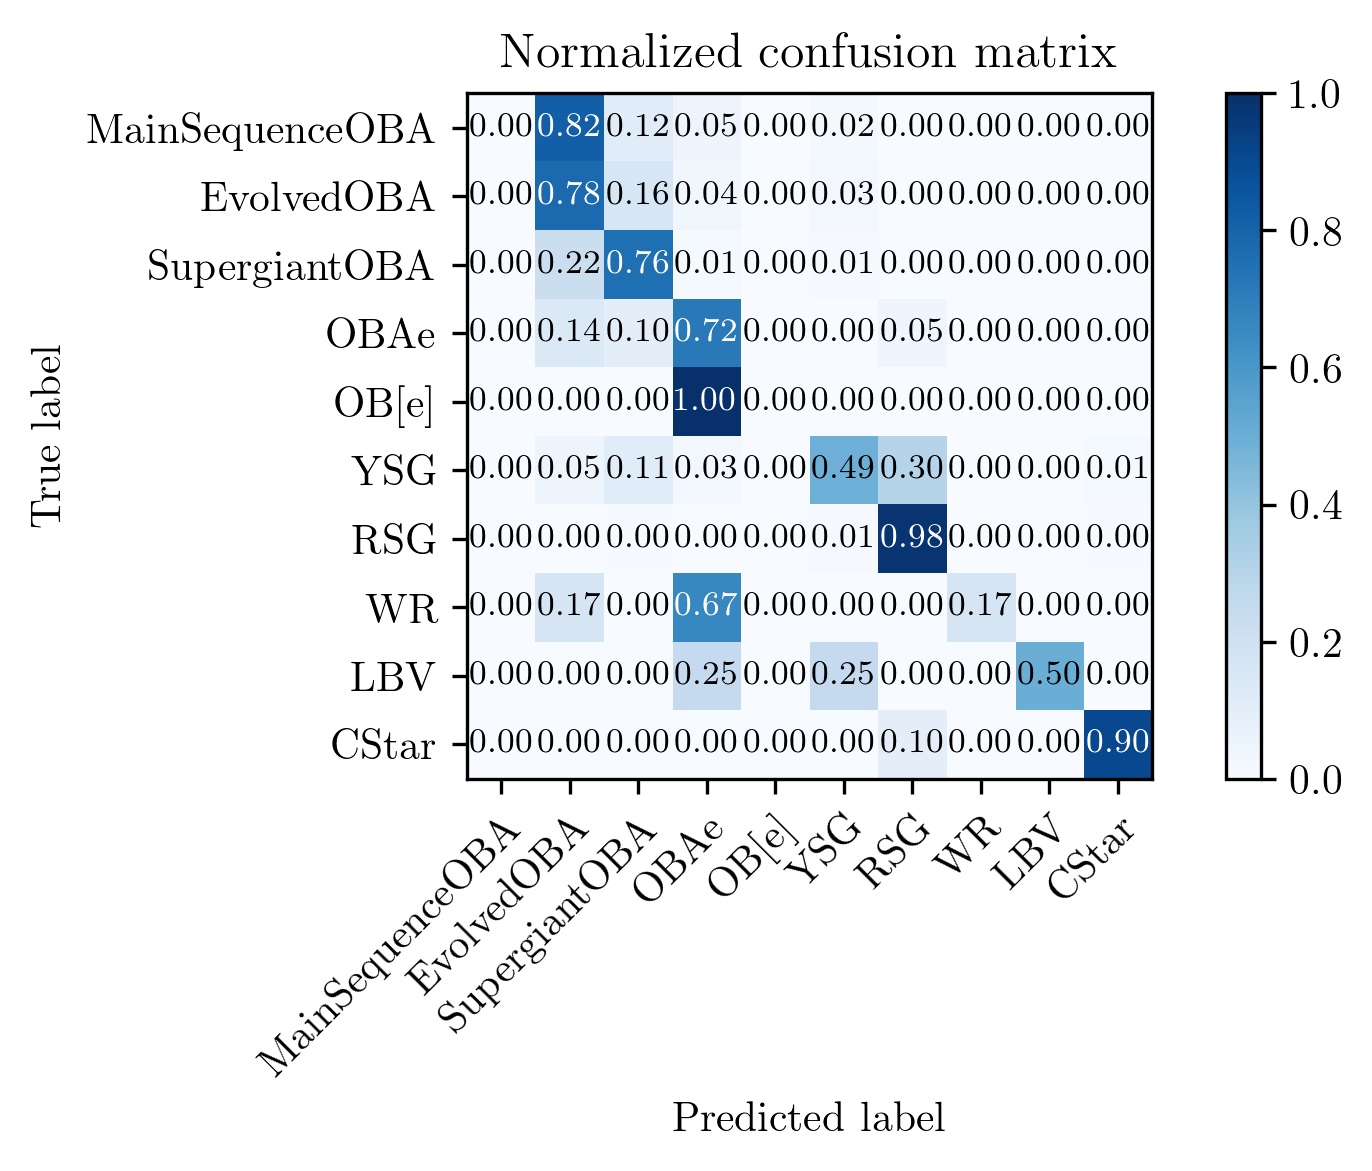

In [6]:
classes = ['MainSequenceOBA','EvolvedOBA','SupergiantOBA','OBAe','OB[e]','YSG',
                   'RSG','WR','LBV','CStar']
fig,ax = plot_confusion_matrix(y_test, y_check_DT, classes=classes, normalize=True);
fig.dpi = 300
plt.savefig('confusion_colors_only.pdf');

# Random Forest trained on adjacent colors and G/W1 absolute mags

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=np.random.randint(1))

params = {'max_depth': [2,3,4,5,6,7,8,9,10,None],'n_estimators':np.arange(10,110,10),
         'max_features': ['sqrt','log2',None]}

grid = GridSearchCV(RandomForestClassifier(n_jobs=-1), params, cv=4)
grid.fit(X_train, y_train)

forrest = grid.best_estimator_
max_depth = forrest.max_depth
max_features = forrest.max_features
n_estimators = forrest.n_estimators
print('Random Forrest with max_depth set to :')
print(max_depth)
print('max_features set to :')
print(max_features)
print('and n_estimators set to :')
print(n_estimators)
forrest.fit(X,y)
y_check_RF = forrest.predict(X_test)

Random Forrest with max_depth set to :
7
max_features set to :
log2
and n_estimators set to :
40


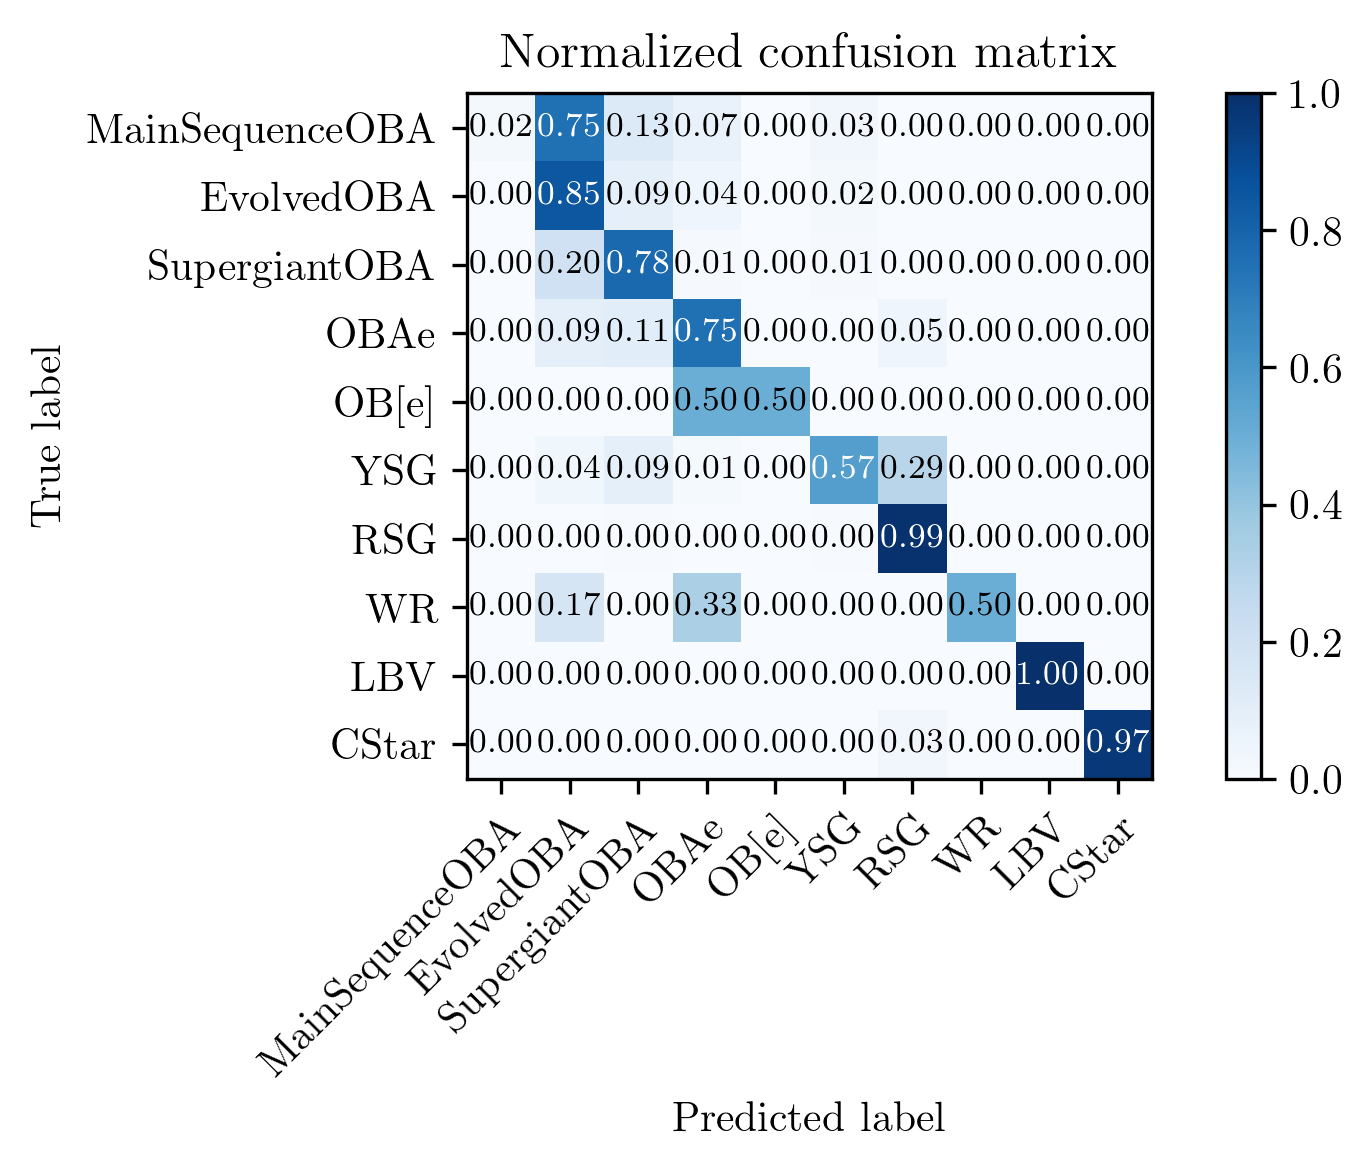

In [8]:
fig,ax = plot_confusion_matrix(y_test, y_check_RF,classes=classes,normalize=True);
fig.dpi = 300
plt.savefig('confusion_colors_RF.pdf');

# Random Forest trained on colors, mags, and W1, W2, and W1-W2 variability metrics

In [9]:
X[['W1chi2red','W2chi2red','W1-W2chi2red','W1_EWM','W2_EWM','W1-W2_EWM']] = training_data[[
   'W1chi2red','W2chi2red','W1-W2chi2red','W1_EWM','W2_EWM','W1-W2_EWM']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=np.random.randint(1))

params = {'max_depth': [2,3,4,5,6,7,8,9,10,None],'n_estimators':np.arange(10,110,10),
         'max_features': ['sqrt','log2',None]}

grid = GridSearchCV(RandomForestClassifier(n_jobs=-1), params, cv=4)

grid.fit(X_train, y_train)

forrest = grid.best_estimator_
max_depth = forrest.max_depth
max_features = forrest.max_features
n_estimators = forrest.n_estimators
print('Random Forrest with max_depth set to :')
print(max_depth)
print('max_features set to :')
print(max_features)
print('and n_estimators set to :')
print(n_estimators)
forrest.fit(X,y)
y_check_RF_var = forrest.predict(X_test)

/Users/carina/anaconda/lib/python3.5/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


Random Forrest with max_depth set to :
8
max_features set to :
sqrt
and n_estimators set to :
70


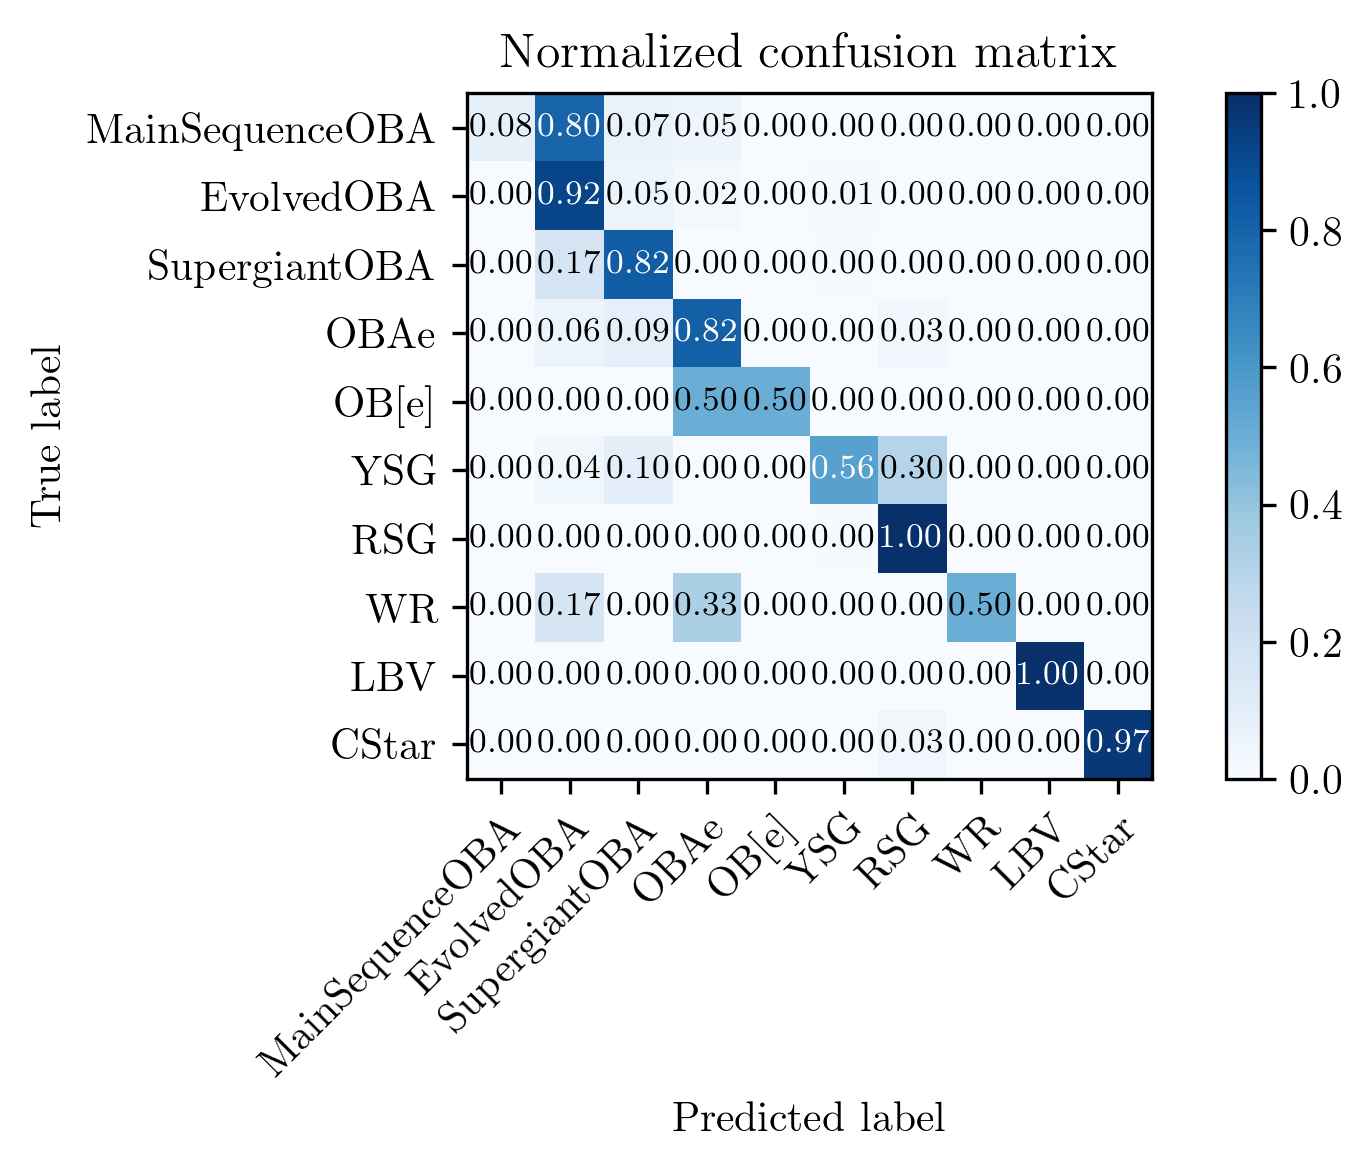

In [10]:
fig,ax = plot_confusion_matrix(y_test, y_check_RF_var,classes=classes,normalize=True);
fig.dpi = 300
plt.savefig('confusion_variability_RF.pdf');

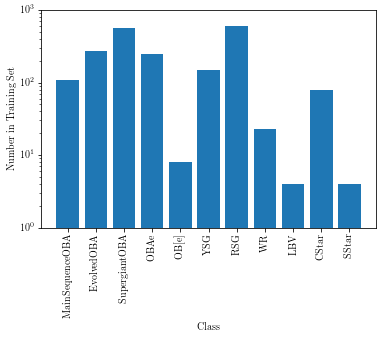

In [11]:
#How many of each class are there in the training and test set?
num_input = []
test_classes = ['MainSequenceOBA','EvolvedOBA','SupergiantOBA','OBAe','OB[e]','YSG',
                   'RSG','WR','LBV','CStar','SStar']
for test_class in test_classes:
    num = len(y_train[y_train == test_class])
    num_input.append(num)
plt.bar(np.arange(len(test_classes)),num_input)
plt.yscale('log')
plt.xticks(ticks=np.arange(len(test_classes)),labels=test_classes,rotation='vertical');
plt.xlabel('Class')
plt.ylabel('Number in Training Set')
plt.ylim(1,1000);

(1, 300)

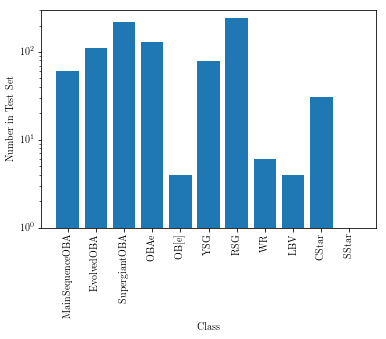

In [12]:
#How many of each class are there in the training and test set?
num_input = []
for test_class in test_classes:
    num = len(y_test[y_test == test_class])
    num_input.append(num)
plt.bar(np.arange(len(test_classes)),num_input)
plt.yscale('log')
plt.xticks(ticks=np.arange(len(test_classes)),labels=test_classes,rotation='vertical');
plt.xlabel('Class')
plt.ylabel('Number in Test Set')
plt.ylim(1,300)

(1, 5000)

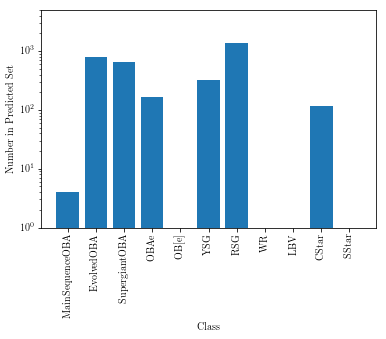

In [13]:
unknown_indices = [c in np.array(['Misc. Variable','OBA','Unknown/Candidate']) 
 for c in joined['Class']]
unknowns = joined[unknown_indices].fillna(value=-999)
unknowns_data = unknowns[['G-J','J-H','H-K','K-W1','W1-W2','W2-W3','W3-W4','M_G','M_W1',
                          'W1chi2red','W2chi2red','W1-W2chi2red','W1_EWM','W2_EWM',
                          'W1-W2_EWM']]
unknown_classes = forrest.predict(unknowns_data)
num_output = []
for pred_class in test_classes:
    num = len(unknown_classes[unknown_classes == pred_class])
    num_output.append(num)
plt.bar(np.arange(len(test_classes)),num_output)
plt.yscale('log')
plt.xticks(ticks=np.arange(len(test_classes)),labels=test_classes,rotation='vertical')
plt.xlabel('Class')
plt.ylabel('Number in Predicted Set')
plt.ylim(1,5000)

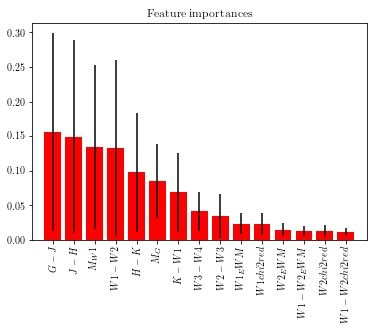

In [14]:
importances = forrest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forrest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
plt.title("Feature importances")
plt.bar(np.arange(len(X.columns[indices])), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(ticks=np.arange(len(X.columns[indices])),labels=['${0}$'.format(name) for name in X.columns[indices]],rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.savefig('feature_importance_RF.pdf')

# Random Forest trained on the SEDs (extinction corrected in G)

In [31]:
X_mags = training_data[['M_G','M_W1']]
dist_mod = []
for i,row in training_data.iterrows():
    if row['Galaxy'] == 'Milky Way':
        dist_mod.append(5.0*np.log10(row['r_est']) - 5.0)
    elif row['Galaxy'] == 'LMC':
        dist_mod.append(18.52)
    elif row['Galaxy'] == 'SMC':
        dist_mod.append(19.05)
X_mags.insert(1,'M_J',training_data['Jmag'].values - dist_mod)
X_mags.insert(2,'M_H',training_data['Hmag'].values - dist_mod)
X_mags.insert(3,'M_K',training_data['Kmag'].values - dist_mod)
X_mags.insert(5,'M_W2',training_data['w2mpro'].values - dist_mod)
X_mags.insert(6,'M_W3',training_data['w3mpro'].values - dist_mod)
X_mags.insert(7,'M_W4',training_data['w4mpro'].values - dist_mod)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X_mags, y, test_size=0.3, random_state=np.random.randint(1))

params = {'max_depth': [2,3,4,5,6,7,8,9,10,None],'n_estimators':np.arange(10,110,10),
         'max_features': ['sqrt','log2',None]}

grid = GridSearchCV(RandomForestClassifier(n_jobs=-1), params, cv=4)
grid.fit(X_train, y_train)

forrest = grid.best_estimator_
max_depth = forrest.max_depth
max_features = forrest.max_features
n_estimators = forrest.n_estimators
print('Random Forrest with max_depth set to :')
print(max_depth)
print('max_features set to :')
print(max_features)
print('and n_estimators set to :')
print(n_estimators)
forrest.fit(X_mags,y)
y_check_RF_mags = forrest.predict(X_test)

Random Forrest with max_depth set to :
10
max_features set to :
None
and n_estimators set to :
40


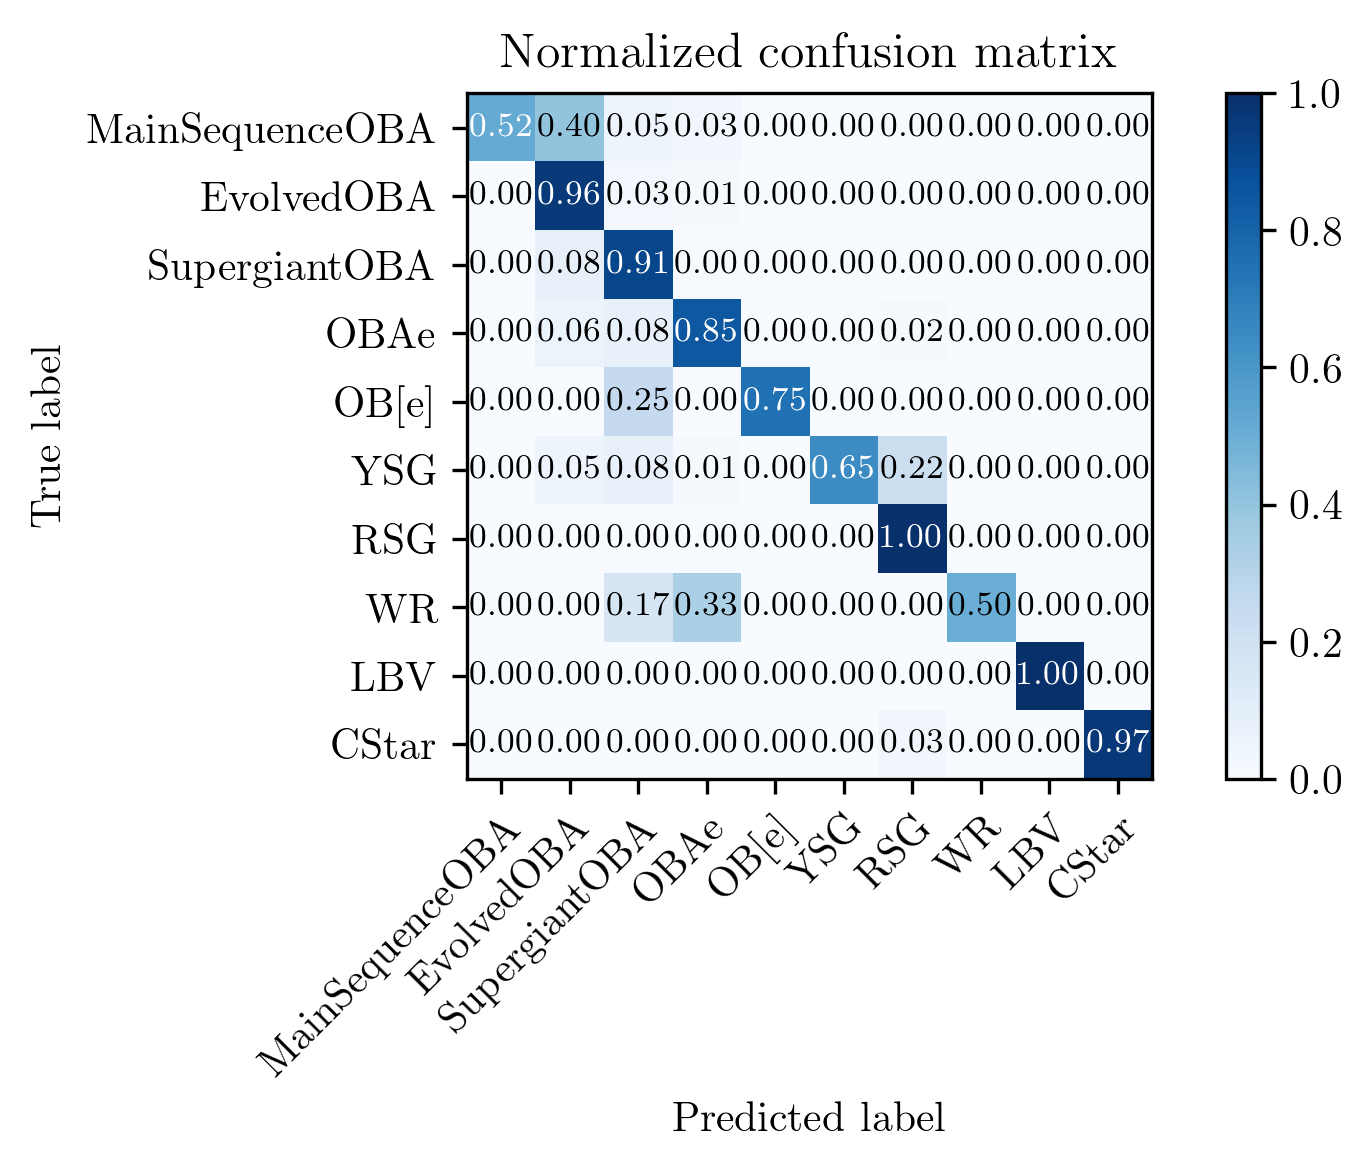

In [39]:
fig,ax = plot_confusion_matrix(y_test, y_check_RF_mags,classes=classes,normalize=True);
fig.dpi = 300
plt.savefig('confusion_mags.pdf');

# SED + Variability?

In [38]:
X_mags[['W1chi2red','W2chi2red','W1-W2chi2red','W1_EWM','W2_EWM','W1-W2_EWM']] = training_data[[
   'W1chi2red','W2chi2red','W1-W2chi2red','W1_EWM','W2_EWM','W1-W2_EWM']]

X_train, X_test, y_train, y_test = train_test_split(
    X_mags, y, test_size=0.3, random_state=np.random.randint(1))

params = {'max_depth': [2,3,4,5,6,7,8,9,10,None],'n_estimators':np.arange(10,110,10),
         'max_features': ['sqrt','log2',None]}

grid = GridSearchCV(RandomForestClassifier(n_jobs=-1), params, cv=4)

grid.fit(X_train, y_train)

forrest = grid.best_estimator_
max_depth = forrest.max_depth
max_features = forrest.max_features
n_estimators = forrest.n_estimators
print('Random Forrest with max_depth set to :')
print(max_depth)
print('max_features set to :')
print(max_features)
print('and n_estimators set to :')
print(n_estimators)
forrest.fit(X_mags,y)
y_check_magvar = forrest.predict(X_test)

/Users/carina/anaconda/lib/python3.5/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


Random Forrest with max_depth set to :
8
max_features set to :
log2
and n_estimators set to :
80


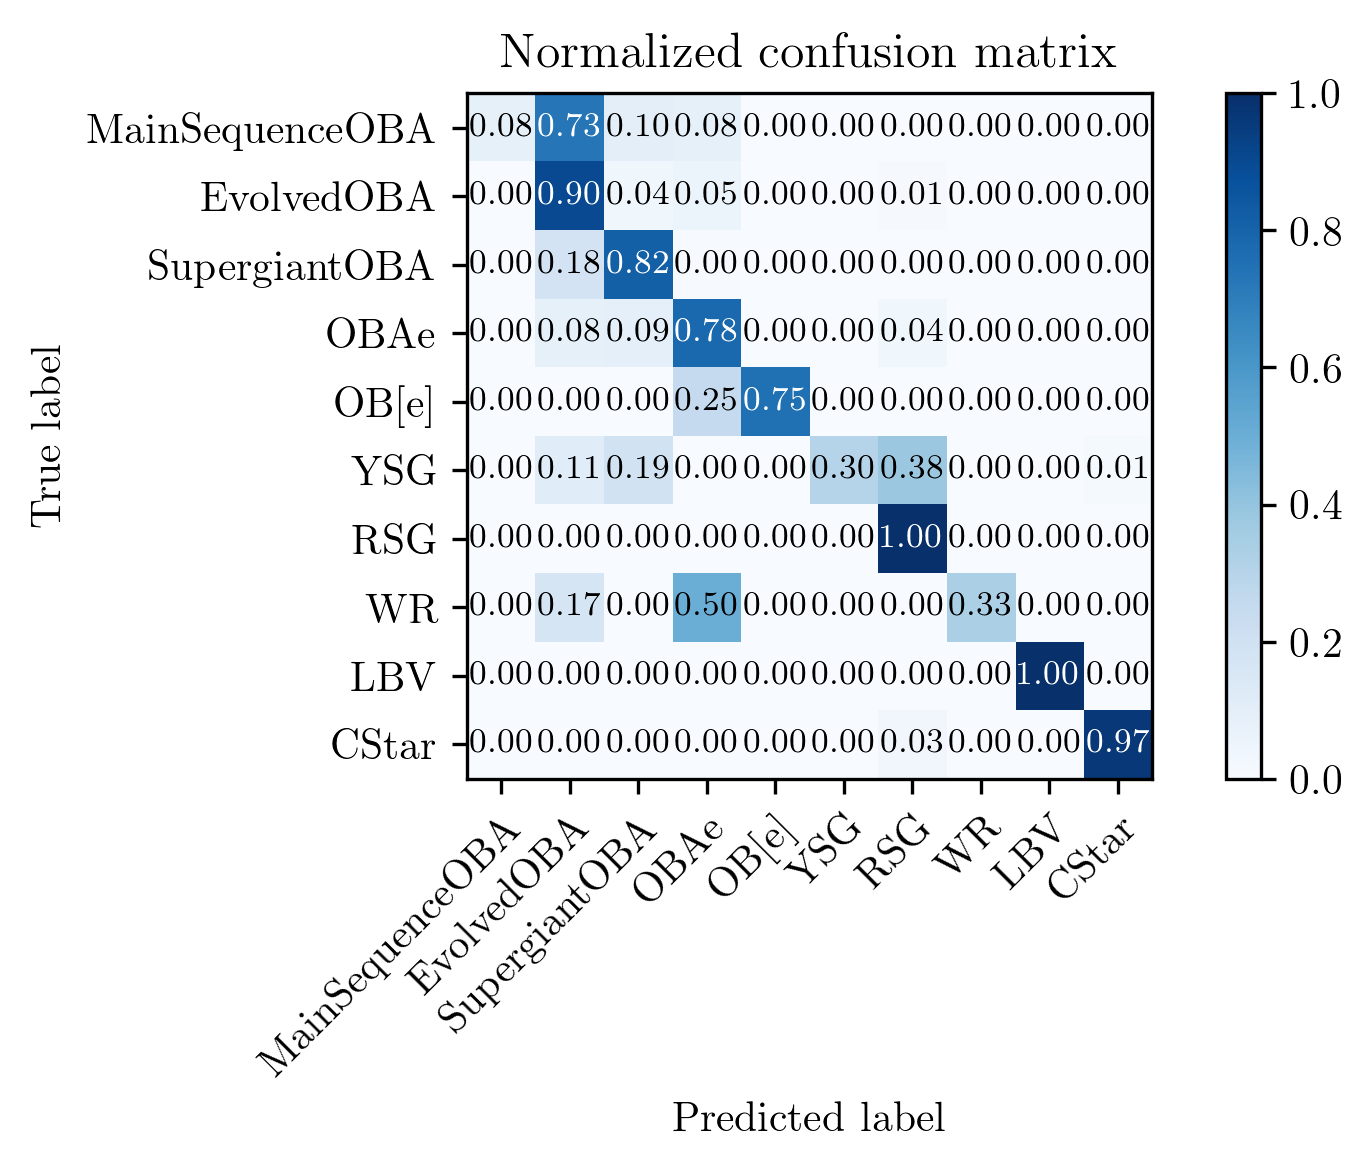

In [40]:
fig,ax = plot_confusion_matrix(y_test, y_check_magvar,classes=classes,normalize=True);
fig.dpi = 300
plt.savefig('confusion_magvar.pdf');

# SED + Variability + Numeric Metallicity Code?

In [41]:
num_met = []
for i,row in training_data.iterrows():
    if row['Galaxy'] == 'Milky Way':
        num_met.append(2)
    elif row['Galaxy'] == 'LMC':
        num_met.append(1)
    elif row['Galaxy'] == 'SMC':
        num_met.append(0)
X_mags.insert(8,'Numerical Metallicity',num_met)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X_mags, y, test_size=0.3, random_state=np.random.randint(1))

params = {'max_depth': [2,3,4,5,6,7,8,9,10,None],'n_estimators':np.arange(10,110,10),
         'max_features': ['sqrt','log2',None]}

grid = GridSearchCV(RandomForestClassifier(n_jobs=-1), params, cv=4)

grid.fit(X_train, y_train)

forrest = grid.best_estimator_
max_depth = forrest.max_depth
max_features = forrest.max_features
n_estimators = forrest.n_estimators
print('Random Forrest with max_depth set to :')
print(max_depth)
print('max_features set to :')
print(max_features)
print('and n_estimators set to :')
print(n_estimators)
forrest.fit(X_mags,y)
y_check_magvarmet = forrest.predict(X_test)

Random Forrest with max_depth set to :
8
max_features set to :
log2
and n_estimators set to :
50


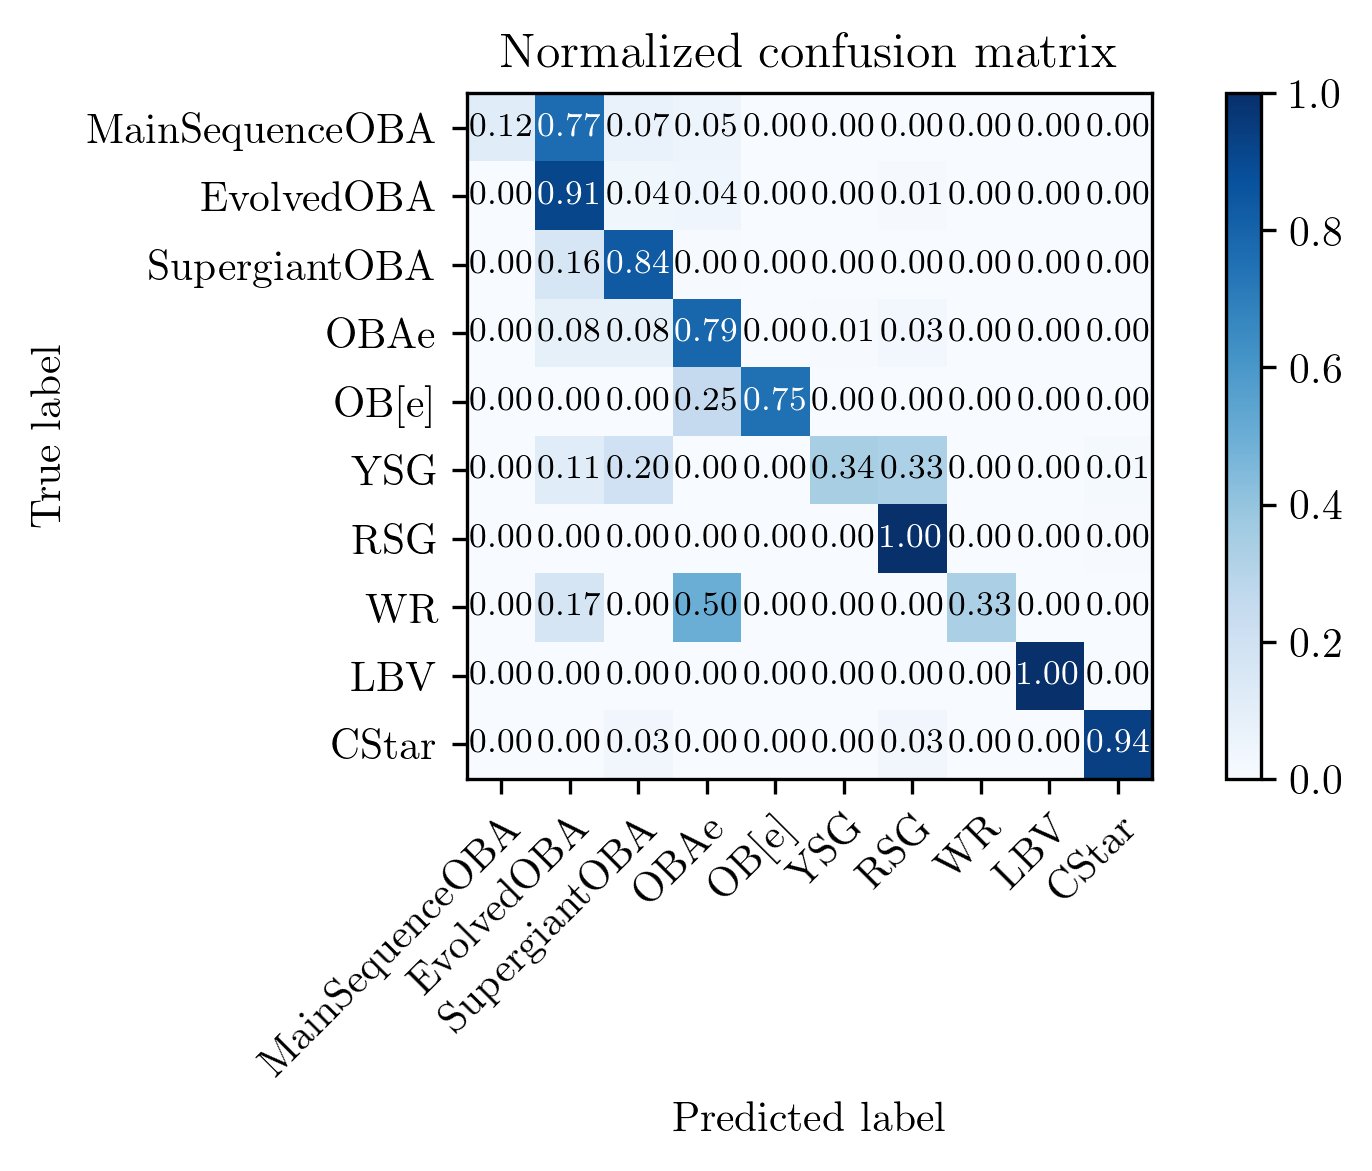

In [43]:
fig,ax = plot_confusion_matrix(y_test, y_check_magvarmet,classes=classes,normalize=True);
fig.dpi = 300
plt.savefig('confusion_magvarmet.pdf');

# Color, M_G, M_W1, variability, and metallicity?

In [46]:
X_all = training_data[['G-J','J-H','H-K','K-W1','W1-W2','W2-W3','W3-W4','M_G','M_W1',
                      'W1chi2red','W2chi2red','W1-W2chi2red','W1_EWM','W2_EWM','W1-W2_EWM']]

X_all.insert(X_all.values.shape[1],'Numerical Metallicity',num_met)

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y, test_size=0.3, random_state=np.random.randint(1))

params = {'max_depth': [2,3,4,5,6,7,8,9,10,None],'n_estimators':np.arange(10,110,10),
         'max_features': ['sqrt','log2',None]}

grid = GridSearchCV(RandomForestClassifier(n_jobs=-1), params, cv=4)

grid.fit(X_train, y_train)

forrest = grid.best_estimator_
max_depth = forrest.max_depth
max_features = forrest.max_features
n_estimators = forrest.n_estimators
print('Random Forrest with max_depth set to :')
print(max_depth)
print('max_features set to :')
print(max_features)
print('and n_estimators set to :')
print(n_estimators)
forrest.fit(X_all,y)
y_check_all = forrest.predict(X_test)

Random Forrest with max_depth set to :
8
max_features set to :
sqrt
and n_estimators set to :
20


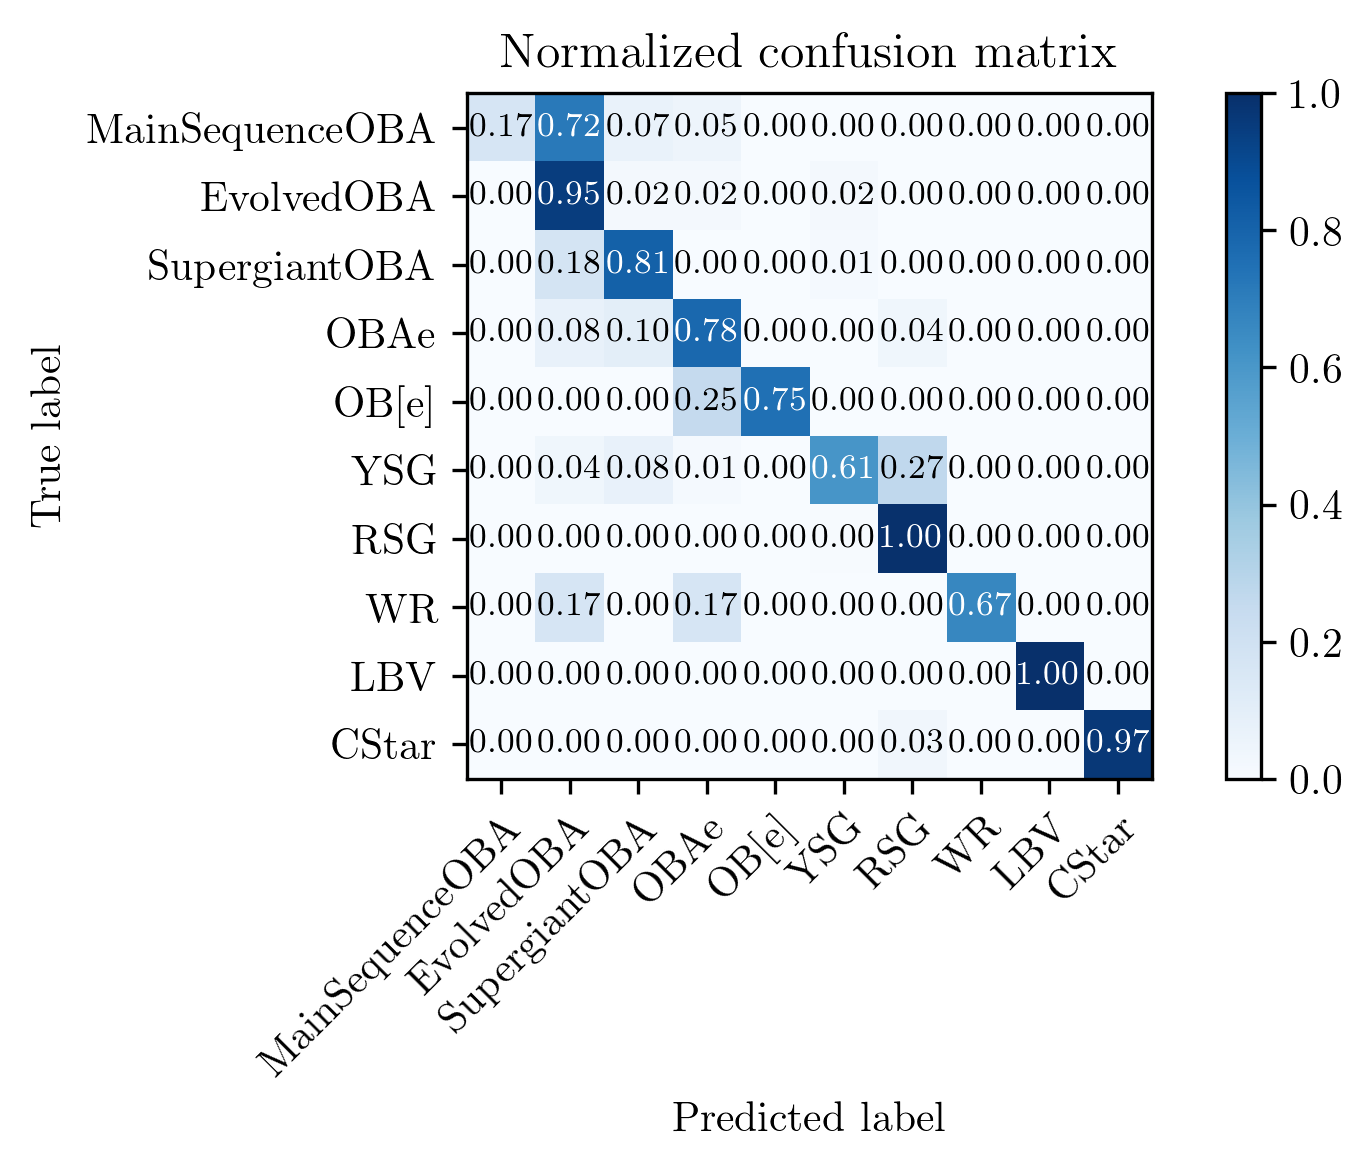

In [47]:
fig,ax = plot_confusion_matrix(y_test, y_check_all,classes=classes,normalize=True);
fig.dpi = 300
plt.savefig('confusion_colvarmet.pdf');